# Myocardial Rupture Prediction Using Random Forest and Neural Network

#### Acute myocardial infarction has been increasing according to American Heart Association. While myocardial infarction could be hereditary, unhealthy lifestyle could also lead to this disease. Unfortunately, patients suffering from myocardial infarction have complications leading to worsening of the disease, particularly myocardial rupture which most of the time leads to patients death. This project aims to predict patients' myocardial rupture after being hospitalized from myocardial infarction using random forest and neural network.

## Importing Data

In [310]:
import pandas as pd
df = pd.read_csv('Myocardial infarction complications Database.csv', sep=',')
print('Download Link: https://figshare.le.ac.uk/articles/dataset/Myocardial_infarction_complications_Database/12045261/3')
print('Source: University of Leicester')

Download Link: https://figshare.le.ac.uk/articles/dataset/Myocardial_infarction_complications_Database/12045261/3
Source: University of Leicester


In [311]:
# drop column ID
df.drop(df.columns[0], axis=1, inplace=True)

label = list(df.columns)

input_label = label[0:111]
target_feature = label[117]

print(f'Number of features used for input: {len(input_label)}')
print(f'Output of interest: {target_feature}')

Number of features used for input: 111
Output of interest: RAZRIV


#### Our target feature is RAZRIV(Myocardial Rupture). 1 signifies the patient experienced myocardial rupture, 0 otherwise.

## Imputation

In [312]:
# Number of missing values
miss = df.isnull().sum().sum()
print(f'Number of missing values: {miss}')

Number of missing values: 15974


In [313]:
# Fill missing values with column mode
for col in df.columns:
    df[col] = df[col].fillna(df[col].mode()[0])

# Number of missing values
miss = df.isnull().sum().sum()
print(f'Number of missing values after imputation: {miss}')

Number of missing values after imputation: 0


In [314]:
counts = df[target_feature].value_counts()
print(counts)

RAZRIV
0    1646
1      54
Name: count, dtype: int64


#### Mode of each input feature is used to fill in the missing values because all inputs are categorical variable. Notice that there is imbalance in our target feature which may lead to classification inaccuracy and poor generalization. This issue is dealt later using Synthetic Minority Over-Sampling Technique(SMOTE).

## Splitting Training and Testing Set

#### Train and test sets are split into 80/20 ratio.

In [315]:
df = df.sample(frac=1).reset_index(drop=True)
num_rows, num_columns = df.shape
df_train = df.head(int(num_rows*0.8)) #80%
df_test = df.tail(int(num_rows*0.2)) #20%

In [316]:
X_train = df_train.drop(target_feature, axis=1)
y_train = df_train[target_feature]
X_test = df_test.drop(target_feature, axis=1)
y_test = df_test[target_feature]

## Random Forest

#### First, we try to predict using random forest. We optimize the hyperparameters using random search due to our limitation of our hardware.

In [317]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

random_grid = {
    'n_estimators': randint(100, 1000),  # Number of trees in the forest
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at every split
    'max_depth': randint(10, 100),  # Maximum number of levels in tree
    'min_samples_split': uniform(0.01, 0.199),  # Minimum number of samples required to split a node
    'min_samples_leaf': uniform(0.01, 0.049),  # Minimum number of samples required at each leaf node
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)

rf_random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=100,  # 100 iterations
    scoring='f1',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_random_search.fit(X_train, y_train)

best_params_rf = rf_random_search.best_params_
best_score_rf = rf_random_search.best_score_

print("Best Hyperparameters:", best_params_rf)
print("Best precision Score:", best_score_rf)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
180 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
82 fits failed with the following error:
Traceback (most recent call last):
  File "C:\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_

Best Hyperparameters: {'bootstrap': False, 'max_depth': 67, 'max_features': 'sqrt', 'min_samples_leaf': 0.011494512247013422, 'min_samples_split': 0.017432289561093668, 'n_estimators': 937}
Best precision Score: 0.5810224089635854


#### Apply SMOTE to our training set to solve imbalance in our dataset.

In [318]:
print(f'Number of records in train set: {len(X_train)}')

# Perform oversampling using SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f'Number of records in train set after SMOTE: {len(X_train_smote)}')

Number of records in train set: 1360
Number of records in train set after SMOTE: 2644


#### Select top 10 features  using mutual information

In [319]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

selector = SelectKBest(score_func=mutual_info_classif,
                       k=10) #Select top 10
X_train_selected = selector.fit_transform(X_train_smote, y_train_smote)

rf_model_selected = RandomForestClassifier(random_state=42, **best_params_rf)
rf_model_selected.fit(X_train_selected, y_train_smote)

X_val_selected = selector.transform(X_test)
rf_val_predictions = rf_model_selected.predict(X_val_selected) # Prediction


cols_idxs = selector.get_support(indices=True)
features_df_new = df.iloc[:,cols_idxs]
features_df_new.columns
print('Top 10 Features')
for i in features_df_new.columns:
    print(i)

Top 10 Features
AGE
lat_im
K_BLOOD
NA_BLOOD
ALT_BLOOD
AST_BLOOD
L_BLOOD
ROE
TIME_B_S
P_IM_STEN


#### Instantiate Random Forest using hyperparameters from random search.

In [320]:
from sklearn.ensemble import RandomForestClassifier
#from sklearn.svm import SVC
X_train_selected = selector.fit_transform(X_train_smote, y_train_smote)

rf_model_selected = RandomForestClassifier(random_state=42, **best_params_rf)
rf_model_selected.fit(X_train_selected, y_train_smote)

X_val_selected = selector.transform(X_test)
rf_val_predictions = rf_model_selected.predict(X_val_selected) # Prediction

Accuracy:  0.9764705882352941
Recall:  1.0


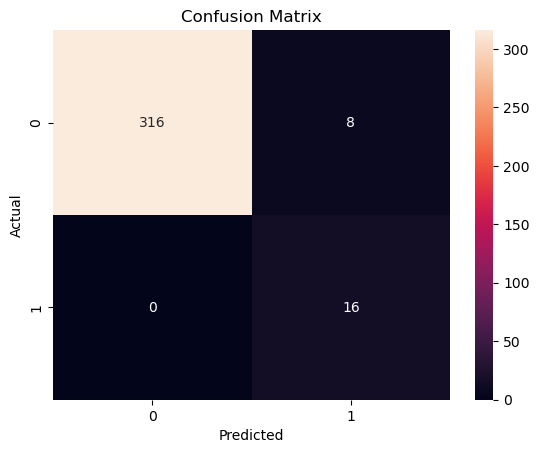

In [321]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

cm = confusion_matrix(y_test, rf_val_predictions)
tn, fp, fn, tp = cm.ravel()


sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual');

print('Accuracy: ', (tp+tn)/(tn+fp+fn+tp))
print('Recall: ', (tp)/(tp+fn))

In [322]:
dd = X_train_smote[['AGE','lat_im','K_BLOOD','NA_BLOOD','ALT_BLOOD','AST_BLOOD','L_BLOOD','ROE','TIME_B_S','P_IM_STEN']]

#### Recall rate is the common evaluation score used in medical fields where false negative is costly than false positive. Our model is showing extremely high recall rate with modestly high accuracy.

## Neural Network

In [337]:
import torch
from torch import nn

# Use cuda if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [338]:
# Convert pandas object to a tensor and unify data type
X_train_tensor = torch.tensor(X_train.values)
X_test_tensor = torch.tensor(X_test.values)
y_train_tensor = torch.tensor(y_train.values, dtype=float)
y_test_tensor = torch.tensor(y_test.values, dtype=float)

In [339]:
# Contruct a model using linear layers
class RAZRIVModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=122, out_features=61, dtype=float)
        self.layer_2 = nn.Linear(in_features=61, out_features=61, dtype=float)
        self.layer_3 = nn.Linear(in_features=61, out_features=30, dtype=float)
        self.layer_4 = nn.Linear(in_features=30, out_features=30, dtype=float)
        self.layer_5 = nn.Linear(in_features=30, out_features=15, dtype=float)
        self.layer_6 = nn.Linear(in_features=15, out_features=7, dtype=float)
        self.layer_7 = nn.Linear(in_features=7, out_features=7, dtype=float)
        self.layer_8 = nn.Linear(in_features=7, out_features=3, dtype=float)
        self.layer_9 = nn.Linear(in_features=3, out_features=3, dtype=float)
        self.layer_10 = nn.Linear(in_features=3, out_features=1, dtype=float)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.layer_10(self.relu(self.layer_9(self.relu(self.layer_8(self.relu(self.layer_7(self.relu(self.layer_6(self.relu(
            self.layer_5(self.relu(self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))))))))))))))

# Instantiate model
model = RAZRIVModel().to(device)
model

RAZRIVModel(
  (layer_1): Linear(in_features=122, out_features=61, bias=True)
  (layer_2): Linear(in_features=61, out_features=61, bias=True)
  (layer_3): Linear(in_features=61, out_features=30, bias=True)
  (layer_4): Linear(in_features=30, out_features=30, bias=True)
  (layer_5): Linear(in_features=30, out_features=15, bias=True)
  (layer_6): Linear(in_features=15, out_features=7, bias=True)
  (layer_7): Linear(in_features=7, out_features=7, bias=True)
  (layer_8): Linear(in_features=7, out_features=3, bias=True)
  (layer_9): Linear(in_features=3, out_features=3, bias=True)
  (layer_10): Linear(in_features=3, out_features=1, bias=True)
  (relu): ReLU()
)

In [340]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.01) # Increment learning rate by 0.01

In [341]:
# Create accuracy function
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

In [342]:
torch.manual_seed(42)

epochs = 100 # 100 iterations

X_train_tensor, y_train_tensor = X_train_tensor.to(device), y_train_tensor.to(device)
X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)

for epoch in range(epochs):
    model.train() # Train
    
    y_logits = model(X_train_tensor).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits, y_train_tensor)
    acc = accuracy_fn(y_true=y_train_tensor, y_pred=y_pred)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model_0.eval() # Test
    with torch.inference_mode():
        test_logits = model(X_test_tensor).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test_tensor)
        test_acc = accuracy_fn(y_true=y_test_tensor, y_pred=test_pred)
    
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.52245, Accuracy: 97.21% | Test loss: 0.52798, Test acc: 95.29%
Epoch: 10 | Loss: 0.49937, Accuracy: 97.21% | Test loss: 0.50617, Test acc: 95.29%
Epoch: 20 | Loss: 0.47710, Accuracy: 97.21% | Test loss: 0.48521, Test acc: 95.29%
Epoch: 30 | Loss: 0.45575, Accuracy: 97.21% | Test loss: 0.46517, Test acc: 95.29%
Epoch: 40 | Loss: 0.43531, Accuracy: 97.21% | Test loss: 0.44603, Test acc: 95.29%
Epoch: 50 | Loss: 0.41573, Accuracy: 97.21% | Test loss: 0.42776, Test acc: 95.29%
Epoch: 60 | Loss: 0.39698, Accuracy: 97.21% | Test loss: 0.41032, Test acc: 95.29%
Epoch: 70 | Loss: 0.37905, Accuracy: 97.21% | Test loss: 0.39369, Test acc: 95.29%
Epoch: 80 | Loss: 0.36192, Accuracy: 97.21% | Test loss: 0.37788, Test acc: 95.29%
Epoch: 90 | Loss: 0.34558, Accuracy: 97.21% | Test loss: 0.36287, Test acc: 95.29%


Accuracy:  0.9529411764705882
Recall:  0.0


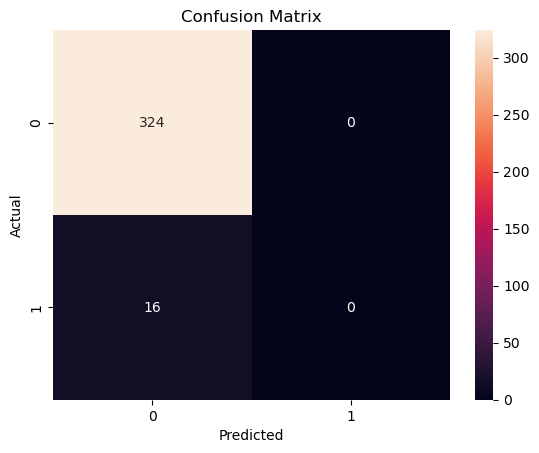

In [343]:
y_test_tensor_cpu = y_test_tensor.cpu().numpy()
test_pred_cpu = test_pred.cpu().numpy()

cm = confusion_matrix(y_test_tensor_cpu, test_pred_cpu)
tn, fp, fn, tp = cm.ravel()


sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual');

print('Accuracy: ', (tp+tn)/(tn+fp+fn+tp))
print('Recall: ', (tp)/(tp+fn))

#### Unlike random forest, recall rate in neural network model is extremely low. This may be due to inappropriate activation function and insufficient hidden layers. It could also be due to the fact that the model was not given recall rate to optimize.

## Conclusion

#### The random forest model successfully predicted the target feature while the neural network model needs some improvement with its recall rate. Though the work is not shown in this code, the most prominent input feature was P_IM_STEN(Post-Infarction Angina). Recall rate suffered when P_IM_STEN was not included compared to other input features. Thus, post-infarction angina could be a determining signal for myocardial rupture.